In [ ]:
! pip install geopandas
! pip install rasterio
! pip install geemap
! pip install cdsapi
!pip install netCDF4
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for multiurl: filename=multiurl-0.3.1-py3-none-any.whl size=21131 sha256=7670dc5bd4ffe0ed7fd9818a358270960a0ed05eb1754c3dca8348aa696b8b07
  Stored in directory: /root/.cache/pip/wheels/9b/d9/5f/36a39fd10d15b5b2d362ad6dc8a1bd28a3b1e14e08357944bf
Successfully built multiurl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 33.1 MB/s eta 0:00:00


## Authenticate Google Earth Engine

In [ ]:
import ee

# Authenticate to GEE
ee.Authenticate()
ee.Initialize(project='ee-anshulya')

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change the directory to where data exists
%pwd
%cd '/content/drive/MyDrive/research/Summer_insitute_2024/atmospheric-rivers'

/content/drive/MyDrive/research/Summer_insitute_2024/atmospheric-rivers


In [ ]:
%ls

CNN-TF.ipynb  data/  era5/  era5-goes2go.ipynb  training-data.ipynb  west_ar.npy


In [ ]:
# import all necessary libraries
import os
from datetime import datetime
import requests as r
import re
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import geemap
import time
import concurrent.futures
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from tqdm import tqdm

## Visualize AR events

In [ ]:
# ar_files = np.load(os.path.join('west_ar.npy'), allow_pickle=True)
# for f in ar_files:
#   # Change the path to your .nc file
#   filename = os.path.join(os.getcwd(),f)

#   try:
#     dataset = nc.Dataset(filename, 'r')
#   except:
#     continue

#   fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(5, 5))

#   lat = dataset.variables['lat'][:]
#   lon = dataset.variables['lon'][:]
#   data = dataset.variables['LABELS'][:]

#   # Set up the map
#   ax.add_feature(cfeature.COASTLINE)
#   ax.add_feature(cfeature.BORDERS, linestyle=':')

#   # Add data to the map
#   ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), cmap='viridis')

#   # Add a colorbar
#   # plt.colorbar(ax=ax, orientation='vertical')

#   # Title and labels
#   ax.set_title(f)
#   ax.set_xlabel('Longitude')
#   ax.set_ylabel('Latitude')
#   ax.set_xlim(-180, -90)
#   ax.set_ylim(0, 90)
#   plt.show()

#   # Close the dataset
#   dataset.close()

1997/10/14

## Get ERA5 data

In [ ]:
%ls -a

.cdsapirc  CNN-TF.ipynb  data/  era5/  era5-goes2go.ipynb  training-data.ipynb  west_ar.npy


In [ ]:
import cdsapi

c = cdsapi.Client(url = 'https://cds.climate.copernicus.eu/api/v2', key = '318692:ba85fe49-c84d-40f1-9a0d-9ae6339d3959')

In [ ]:
# c.retrieve(
#     'reanalysis-era5-pressure-levels',
#     {
#         'product_type': 'reanalysis',
#         'variable': 'specific humidity',
#         'pressure_level': '-1',
#         'year': '2001',
#         'month': '06',
#         'day': '30',
#         'time': '12:00',
#         'format': 'netcdf',                 # Supported format: grib and netcdf. Default: grib
#         # 'area'          : [60, -10, 50, 2], # North, West, South, East.          Default: global
#         'grid'          : [1.0, 1.0],       # Latitude/longitude grid.           Default: 0.25 x 0.25
#     },
#     'era5/era5_spH_sub_area.nc')

###Level listings
**Pressure levels (hPa):** 1000/975/950/925/900/875/850/825/800/775/750/700/650/600/550/500/450/400/350/300/250/225/200/175/150/125/100/70/50/30/20/10/7/5/3/2/1

**Potential temperature levels (K):** 265/275/285/300/315/320/330/350/370/395/430/475/530/600/700/850

**Potential vorticity level (10-9 K m2 kg-1 s-1 or 10-3 PVU):** 2000 (which is representative of the dynamical tropopause)

**Model levels:** 1/to/137, which are described at L137 model level definitions and ERA5: compute pressure and geopotential on model levels, geopotential height and geometric height. The model levels are hybrid pressure/sigma. For more information, see the documentation of the underlying model, ECMWF's IFS, CY41R2, Part III. Dynamics and numerical procedures, Chapter 2 Basic equations and discretisation.

In [31]:
# Example: Download ERA5 data at multiple pressure levels

for day in ['08','09','10','11','12','13','14','15','16','17','18']:
  c.retrieve(
      'reanalysis-era5-pressure-levels',
      {
          'product_type': 'reanalysis',
          'variable': ['specific humidity', 'u wind component', 'v wind component'],
          'pressure_level': ['1000','975', '950', '925', '900', '875', '850', '800', '750', '700', '650', '600', '500', '400', '300'],
          'year': '1997',
          'month': '10',
          'day': day,
          'time': ['00:00','06:00','12:00','18:00'],
          'format': 'netcdf',
          # Add other parameters as needed (e.g., area, grid)
      },
      f'era5/era5_spH_u_v_1997_10_{day}.nc'
  )

2024-06-19 19:42:36,451 INFO Welcome to the CDS
INFO:cdsapi:Welcome to the CDS
2024-06-19 19:42:36,467 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
INFO:cdsapi:Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2024-06-19 19:45:29,494 INFO Request is running
INFO:cdsapi:Request is running
2024-06-19 19:46:56,800 INFO Request is completed
INFO:cdsapi:Request is completed
2024-06-19 19:46:56,805 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data5/adaptor.mars.internal-1718826324.231101-24629-13-ed7168b4-a100-4664-aa71-cde38e8e5eb5.nc to era5/era5_spH_u_v_1997_10_08.nc (356.5M)
INFO:cdsapi:Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data5/adaptor.mars.internal-1718826324.231101-24629-13-ed7168b4-a100-4664-aa71-cde38e8e5eb5.nc to era5/era5_spH_u_v_1997_10_08.nc (356.5M)
2024-06-19 19:49:35,786 INFO Down

In [32]:
def calculate_ivt(filename):
  """
  Calculate Integrated Vapor Transport (IVT) from atmospheric data in a NetCDF file.

  Parameters:
  filename (str): Path to the NetCDF file containing the necessary variables (u, v, q, and level).

  Returns:
  xr.DataArray: IVT calculated from the input data.
  """
  # Constants
  g = 9.81  # Acceleration due to gravity in m/s^2

  # Open the NetCDF file
  ds = xr.open_dataset(filename)

  # Extract the variables
  u = ds['u']  # shape: (time, level, lat, lon)
  v = ds['v']  # shape: (time, level, lat, lon)
  q = ds['q']  # shape: (time, level, lat, lon)
  p = ds['level']  # shape: (level,) - pressure levels

  # Calculate the pressure differences
  dp = p.diff(dim='level') * -1

  # Initialize IVT components
  ivt_u = None
  ivt_v = None

  # Loop over pressure levels
  for i, pi in enumerate(dp):
    # Calculate mid-layer values
    u_mid = (u[:, i, :, :] + u[:, i + 1, :, :]) / 2
    v_mid = (v[:, i, :, :] + v[:, i + 1, :, :]) / 2
    q_mid = (q[:, i, :, :] + q[:, i + 1, :, :]) / 2

    # Calculate IVT components
    ivt_u_component = q_mid * u_mid * pi * 100 / g
    ivt_v_component = q_mid * v_mid * pi * 100 / g

    if ivt_u is None:
      ivt_u = ivt_u_component
      ivt_v = ivt_v_component
    else:
      ivt_u += ivt_u_component
      ivt_v += ivt_v_component

  # Calculate the total IVT
  ivt = np.sqrt(ivt_u**2 + ivt_v**2)

  return ivt

In [33]:
def calculate_iwv(filename):
    """
    Calculate Integrated Water Vapor (IWV) from atmospheric data in a NetCDF file.

    Parameters:
    filename (str): Path to the NetCDF file containing the necessary variables (q and level).

    Returns:
    xr.DataArray: IWV calculated from the input data.
    """
    # Constants
    g = 9.81  # Acceleration due to gravity in m/s^2

    # Open the NetCDF file
    ds = xr.open_dataset(filename)

    # Extract the variables
    q = ds['q']  # shape: (time, level, lat, lon)
    p = ds['level']  # shape: (level,) - pressure levels

    # Calculate the pressure differences
    dp = p.diff(dim='level') * -1

    # Initialize IWV
    iwv = None

    # Loop over pressure levels
    for i, pi in enumerate(dp):
        # Calculate mid-layer specific humidity
        q_mid = (q[:, i, :, :] + q[:, i + 1, :, :]) / 2

        # Calculate IWV component
        iwv_component = q_mid * pi * 100 / g

        if iwv is None:
            iwv = iwv_component
        else:
            iwv += iwv_component

    return iwv

In [38]:
def identify_atmospheric_rivers(ivt, iwv, ivt_threshold=500, iwv_threshold=25, min_length_km=2000, min_width_km=400):
    """
    Identify regions of atmospheric rivers based on IVT, IWV, and geometry criteria.

    Parameters:
    ivt (xr.DataArray): Integrated Vapor Transport (IVT) data.
    iwv (xr.DataArray): Integrated Water Vapor (IWV) data.
    ivt_threshold (float): Threshold for IVT magnitude (default: 250 kg m^-1 s^-1).
    iwv_threshold (float): Threshold for IWV (default: 2 cm).
    min_length_km (float): Minimum length of AR in kilometers (default: 2000 km).
    min_width_km (float): Minimum width of AR in kilometers (default: 500 km).

    Returns:
    xr.DataArray: Binary array indicating regions of atmospheric rivers.
    """
    # Convert minimum length and width from kilometers to grid points
    # Assuming the grid resolution is 0.25 degrees, which is approximately 25 km at the equator
    grid_spacing_km = 25  # Adjust based on actual grid resolution
    min_length_points = min_length_km / grid_spacing_km
    min_width_points = min_width_km / grid_spacing_km

    # Apply IVT and IWV thresholds
    ar_mask = (ivt >= ivt_threshold) & (iwv >= iwv_threshold)

    # Label connected regions
    labeled_ar, num_features = ndimage.label(ar_mask)

    # Initialize an empty mask for the final AR regions
    final_ar_mask = np.zeros_like(labeled_ar, dtype=bool)

    # Loop through each labeled region and apply length and width criteria
    for feature in range(1, num_features + 1):
        feature_mask = (labeled_ar == feature)
        if np.sum(feature_mask) >= (min_length_points * min_width_points):
            final_ar_mask |= feature_mask

    return xr.DataArray(final_ar_mask, coords=ivt.coords, dims=ivt.dims)

In [46]:
time = ['00:00','06:00','12:00','18:00']
for day in ['08','09','10','11','12','13','14','15','16','17','18']:
  filename = f'era5/era5_spH_u_v_1997_10_{day}.nc'
  ivt = calculate_ivt(filename)
  iwv = calculate_iwv(filename)
  ar_regions = identify_atmospheric_rivers(ivt, iwv)

  for t in range(4):
    lat = ivt[t,:,:]['latitude'][:]
    lon = ivt[t,:,:]['longitude'][:]
    data_ivt = ivt[t,:,:].data
    data_iwv = iwv[t,:,:].data

    # thr = np.percentile(data_ivt.flatten(), 95)
    # print(thr)

    # mask_ivt = (data_ivt>thr)

    # Set up the map
    fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8, 3))

    ax[0].add_feature(cfeature.COASTLINE)
    ax[0].add_feature(cfeature.BORDERS, linestyle=':')
    ax[0].contourf(lon, lat, data_ivt, transform=ccrs.PlateCarree(), cmap='Blues')
    ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[0].set_xlim(-180, -90)
    ax[0].set_ylim(0, 90)

    ax[2].add_feature(cfeature.COASTLINE)
    ax[2].add_feature(cfeature.BORDERS, linestyle=':')
    ax[2].contourf(lon, lat,ar_regions[t,:,:], transform=ccrs.PlateCarree(), cmap='Reds',alpha=0.25)
    ax[2].set_xlabel('Longitude')
    ax[2].set_ylabel('Latitude')
    ax[2].set_xlim(-180, -90)
    ax[2].set_ylim(0, 90)

    ax[1].add_feature(cfeature.COASTLINE)
    ax[1].add_feature(cfeature.BORDERS, linestyle=':')
    ax[1].contourf(lon, lat, data_iwv, transform=ccrs.PlateCarree(), cmap='Blues')
    ax[1].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    ax[1].set_xlim(-180, -90)
    ax[1].set_ylim(0, 90)

    plt.suptitle(f'{day} - {time[t]}')
    plt.tight_layout()
    plt.savefig(f'figures/{day} - {time[t]}.png')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [36]:
filename = 'era5/era5_spH_u_v_1997_10_08.nc'
ivt = calculate_ivt(filename)
iwv = calculate_iwv(filename)

In [37]:
ivt

<xarray.DataArray (time: 4, latitude: 721, longitude: 1440)>
array([[[8.22863693e-04, 8.22863693e-04, 8.22863693e-04, ...,
         8.22863693e-04, 8.22863693e-04, 8.22863693e-04],
        [4.07610220e+01, 4.07359213e+01, 4.07054901e+01, ...,
         4.08440139e+01, 4.08236803e+01, 4.07922902e+01],
        [3.86077606e+01, 3.85473213e+01, 3.84914890e+01, ...,
         3.87657356e+01, 3.87107804e+01, 3.86628927e+01],
        ...,
        [3.92384371e+00, 3.92415849e+00, 3.92414705e+00, ...,
         3.91865386e+00, 3.92210339e+00, 3.92223173e+00],
        [3.77546715e+00, 3.77561419e+00, 3.77561004e+00, ...,
         3.77482604e+00, 3.77471156e+00, 3.77427727e+00],
        [4.15290705e-05, 4.15290705e-05, 4.15290705e-05, ...,
         4.15290705e-05, 4.15290705e-05, 4.15290705e-05]],

       [[1.09144795e-03, 1.09144795e-03, 1.09144795e-03, ...,
         1.09144795e-03, 1.09144795e-03, 1.09144795e-03],
        [3.51690202e+01, 3.51514502e+01, 3.51398858e+01, ...,
         3.51984417e+01, 3.51886405e+01, 3.51782551e+01],
        [3.63251358e+01, 3.62965421e+01, 3.62712895e+01, ...,
         3.63821687e+01, 3.63622641e+01, 3.63418310e+01],
...
        [4.04178080e+00, 4.04313190e+00, 4.04448808e+00, ...,
         4.03451184e+00, 4.03871522e+00, 4.04016407e+00],
        [3.98554405e+00, 3.99331370e+00, 3.99409284e+00, ...,
         3.98286062e+00, 3.98371514e+00, 3.98458542e+00],
        [1.91192779e-04, 1.91192779e-04, 1.91192779e-04, ...,
         1.91192779e-04, 1.91192779e-04, 1.91192779e-04]],

       [[1.28956840e-03, 1.28956840e-03, 1.28956840e-03, ...,
         1.28956840e-03, 1.28956840e-03, 1.28956840e-03],
        [7.12676273e+01, 7.12885066e+01, 7.12962448e+01, ...,
         7.12235814e+01, 7.12408823e+01, 7.12590390e+01],
        [7.20302135e+01, 7.20488238e+01, 7.20701871e+01, ...,
         7.19529019e+01, 7.19794196e+01, 7.20047345e+01],
        ...,
        [3.97146379e+00, 3.97413907e+00, 3.98032867e+00, ...,
         3.96376388e+00, 3.96651457e+00, 3.96883127e+00],
        [3.93464807e+00, 3.94084409e+00, 3.94552677e+00, ...,
         3.92997720e+00, 3.93161795e+00, 3.93293500e+00],
        [6.44712104e-05, 6.44712104e-05, 6.44712104e-05, ...,
         6.44712104e-05, 6.44712104e-05, 6.44712104e-05]]])
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1997-10-08 ... 1997-10-08T18:00:00
    level      int32 975

In [18]:
import scipy.ndimage as ndimage

399.322918252493


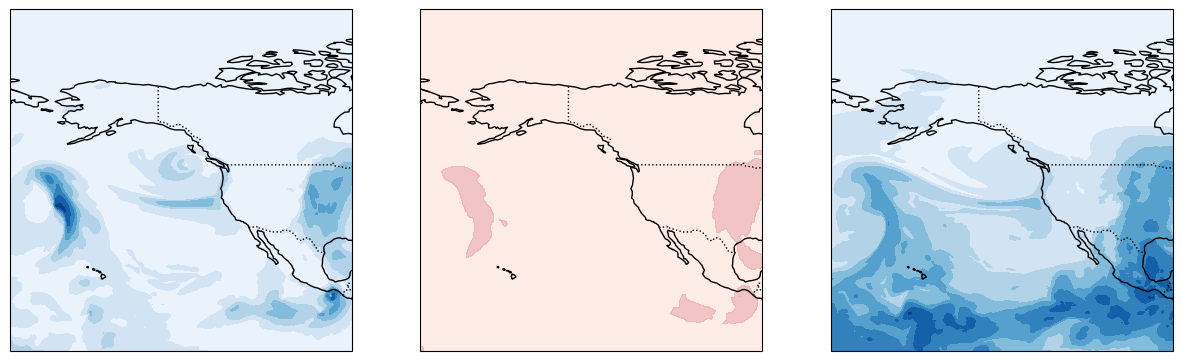

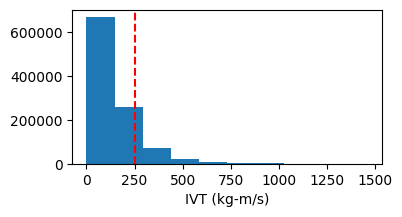

394.83228537778825


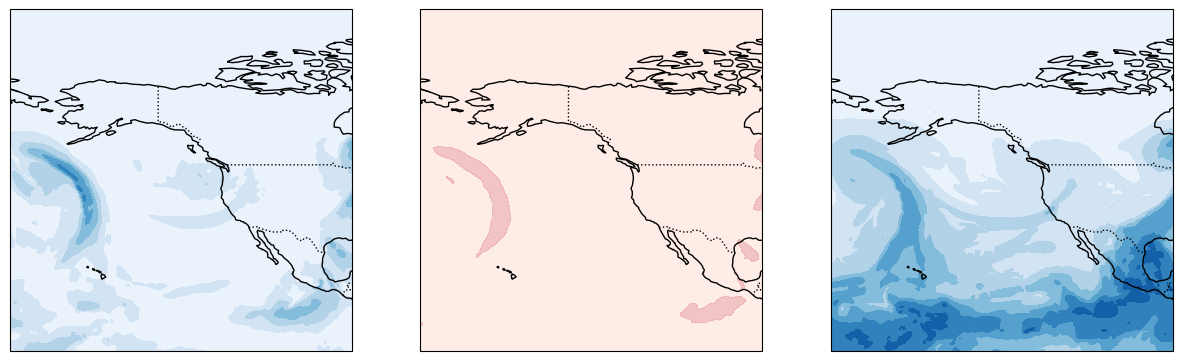

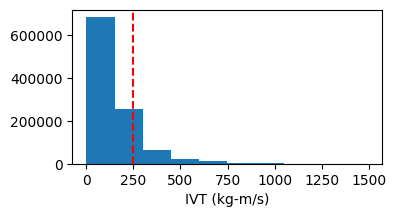

391.21477079718477


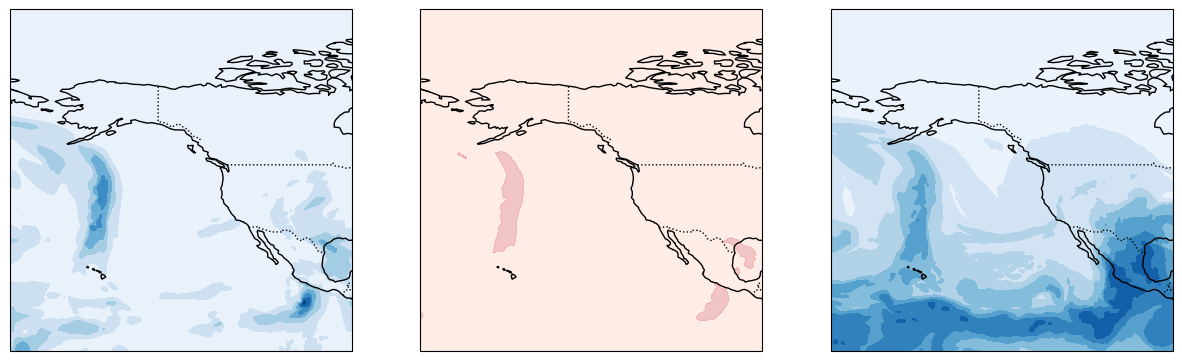

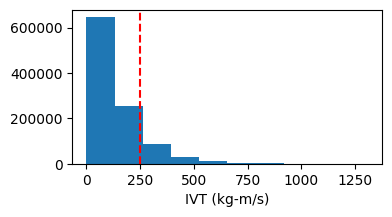

386.4863469240168


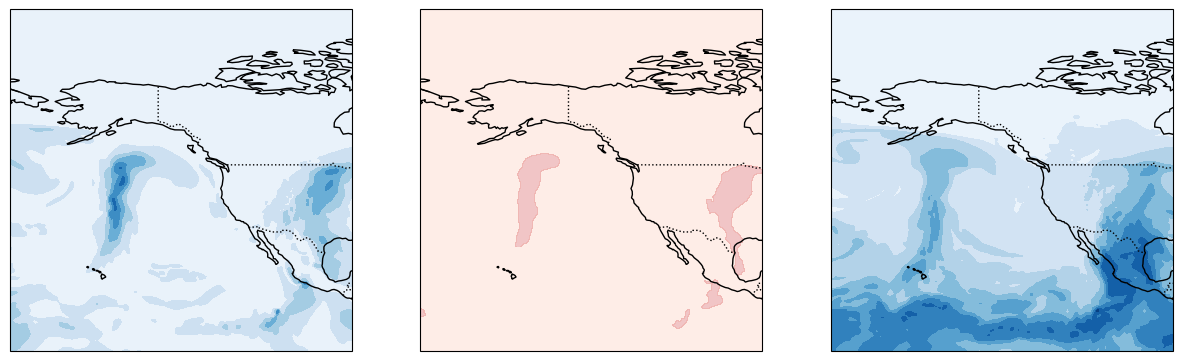

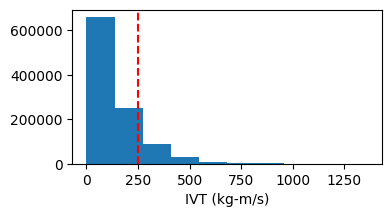

369.0378717714732


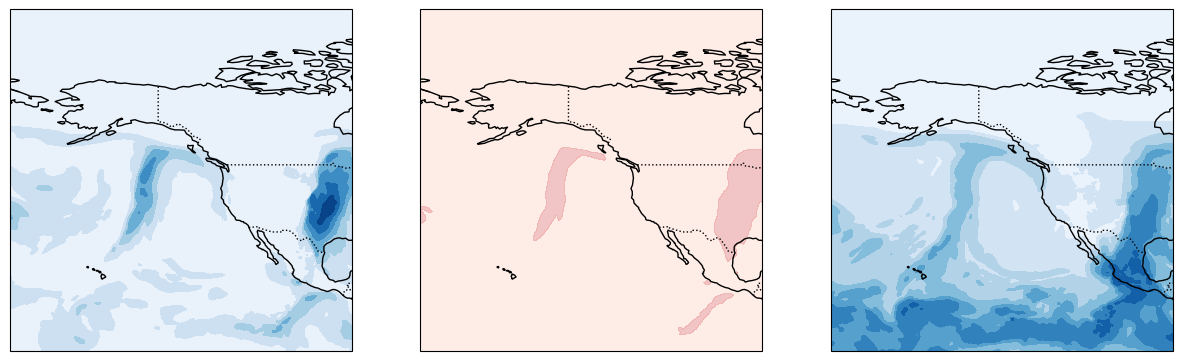

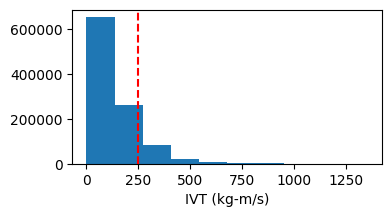

359.0613620016259


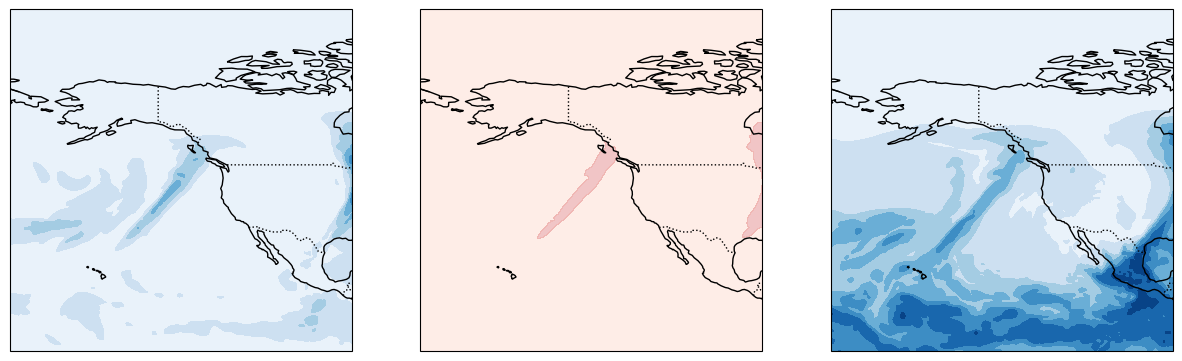

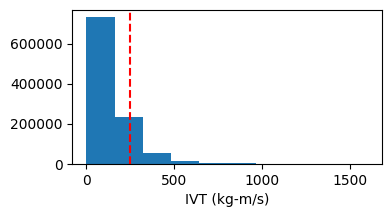

365.8121888365796


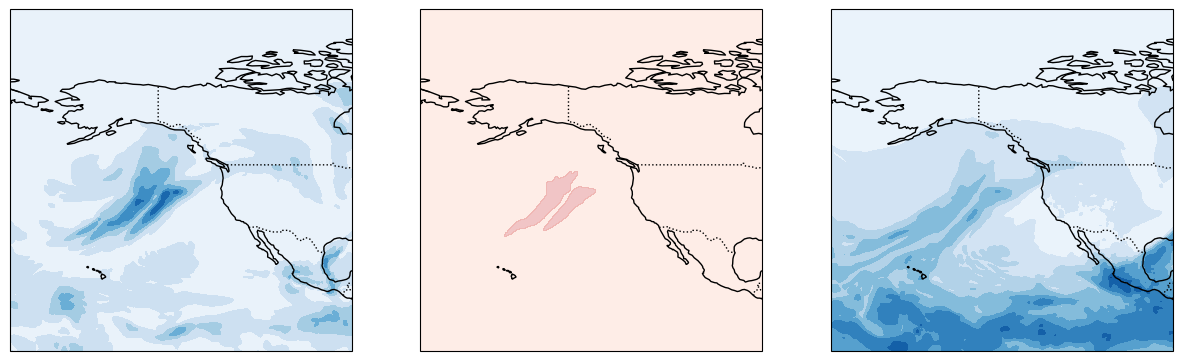

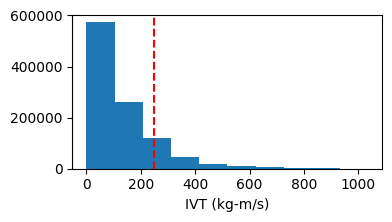

366.0477827511674


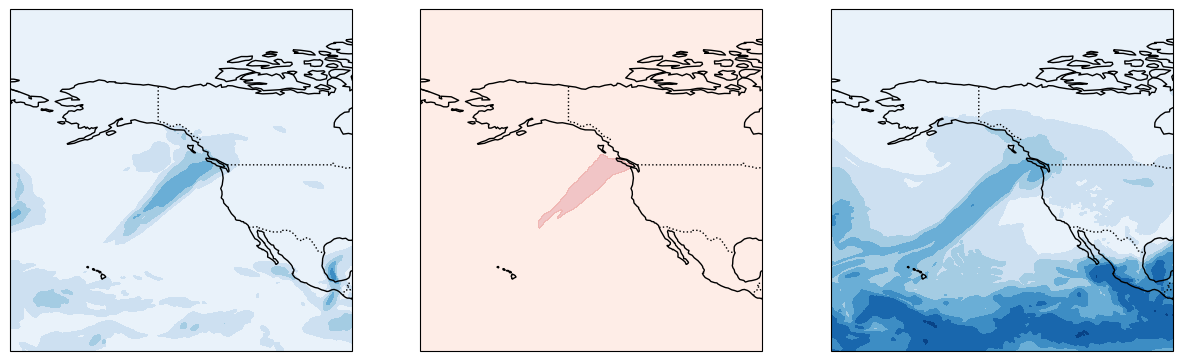

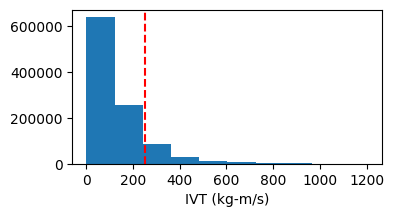

362.027234644626


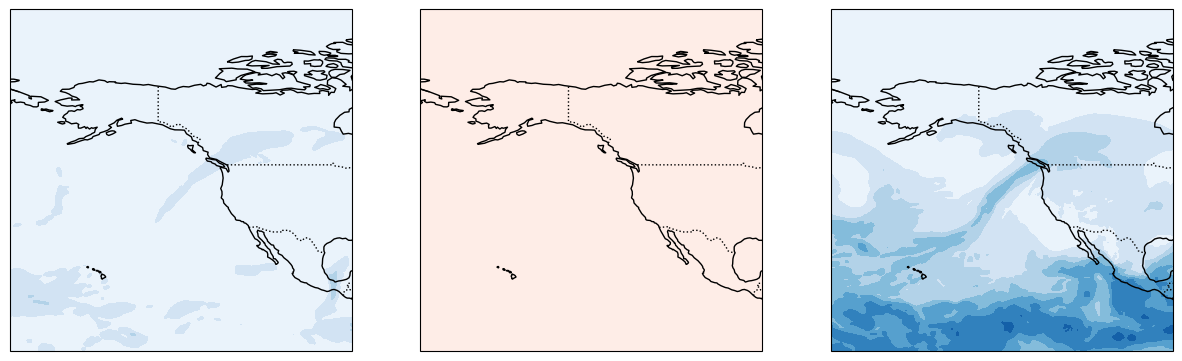

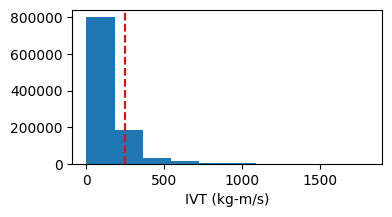

359.93912630031434


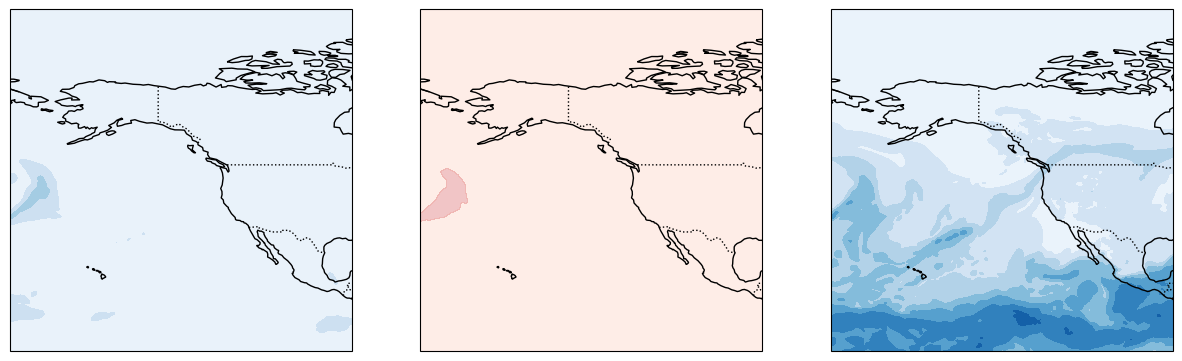

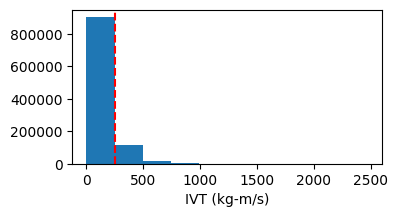

370.2033805487113


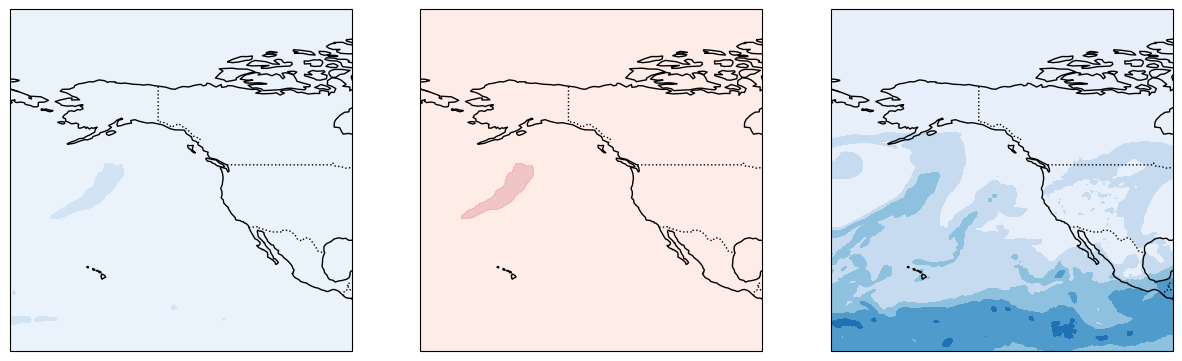

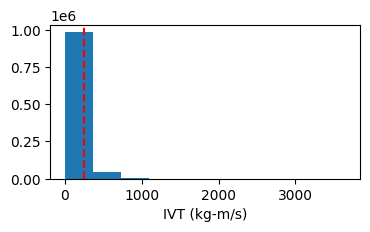

In [27]:
for t in range(11):
  lat = ivt[t,:,:]['latitude'][:]
  lon = ivt[t,:,:]['longitude'][:]
  data_ivt = ivt[t,:,:].data
  data_iwv = iwv[t,:,:].data

  thr = np.percentile(data_ivt.flatten(), 95)
  print(thr)

  mask_ivt = (data_ivt>thr)

  # Set up the map
  fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 5))

  ax[0].add_feature(cfeature.COASTLINE)
  ax[0].add_feature(cfeature.BORDERS, linestyle=':')
  ax[0].contourf(lon, lat, data_ivt, transform=ccrs.PlateCarree(), cmap='Blues')
  ax[0].set_xlabel('Longitude')
  ax[0].set_ylabel('Latitude')
  ax[0].set_xlim(-180, -90)
  ax[0].set_ylim(0, 90)

  ax[1].add_feature(cfeature.COASTLINE)
  ax[1].add_feature(cfeature.BORDERS, linestyle=':')
  ax[1].contourf(lon, lat,ar_regions[t,:,:], transform=ccrs.PlateCarree(), cmap='Reds',alpha=0.25)
  ax[1].set_xlabel('Longitude')
  ax[1].set_ylabel('Latitude')
  ax[1].set_xlim(-180, -90)
  ax[1].set_ylim(0, 90)

  ax[2].add_feature(cfeature.COASTLINE)
  ax[2].add_feature(cfeature.BORDERS, linestyle=':')
  ax[2].contourf(lon, lat, data_iwv, transform=ccrs.PlateCarree(), cmap='Blues')
  ax[2].set_xlabel('Longitude')
  ax[2].set_ylabel('Latitude')
  ax[2].set_xlim(-180, -90)
  ax[2].set_ylim(0, 90)

  plt.show()

  plt.figure(figsize=(4, 2))
  plt.hist(data_ivt.flatten())
  plt.axvline(x=250,color='red',linestyle='--')
  plt.xlabel('IVT (kg-m/s)')
  plt.show()

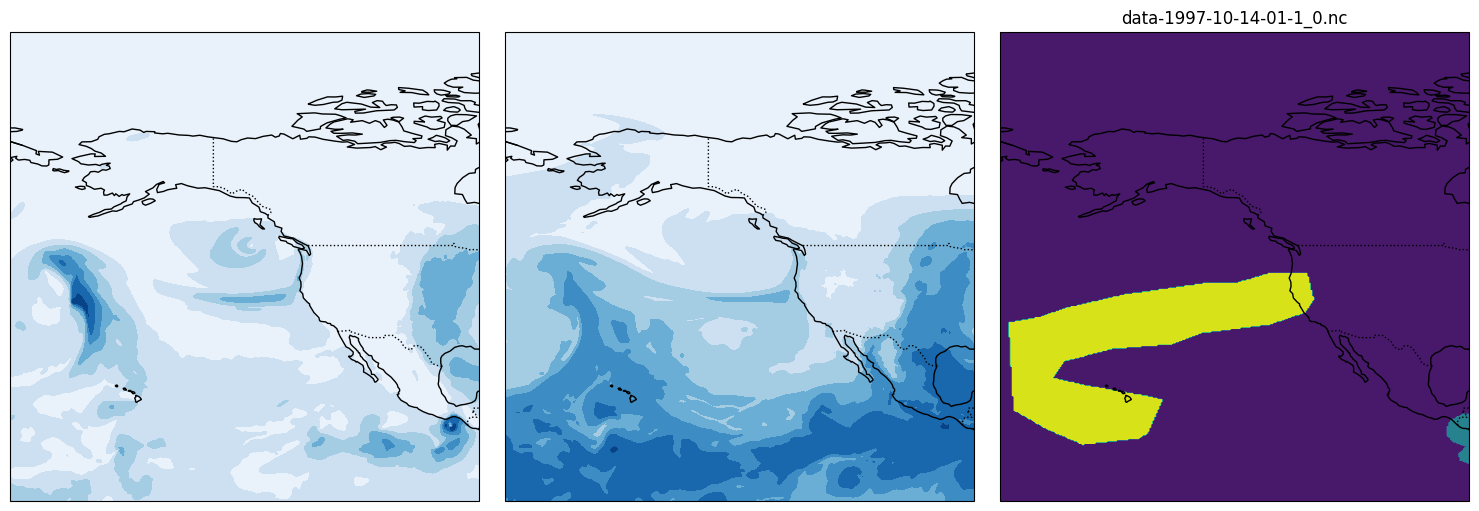

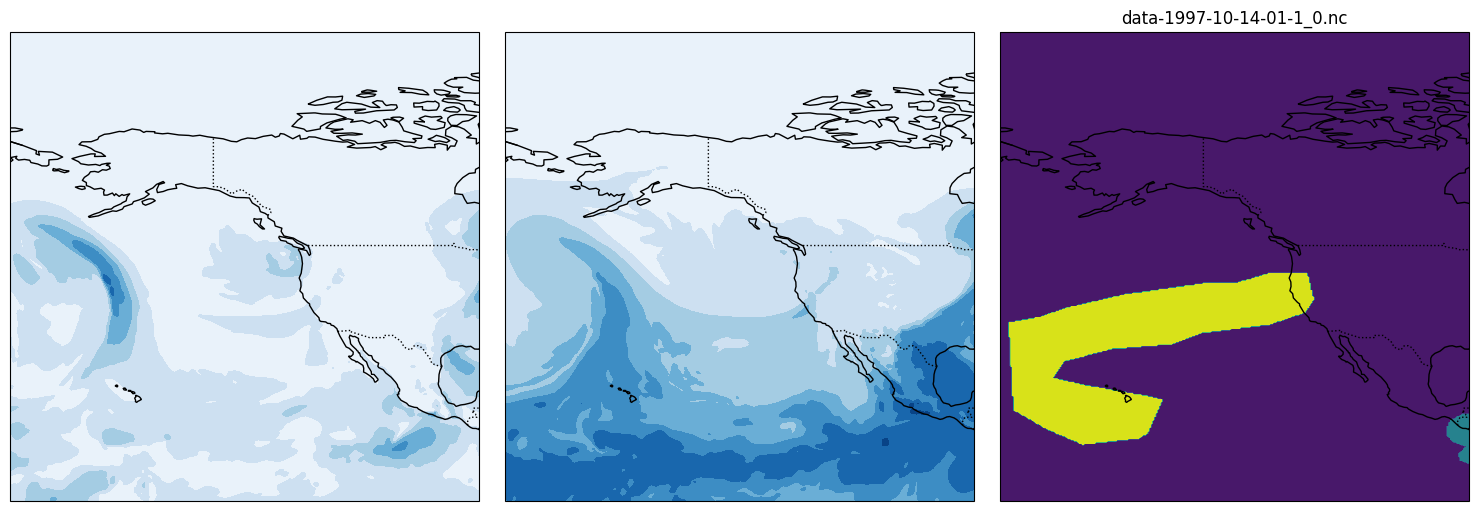

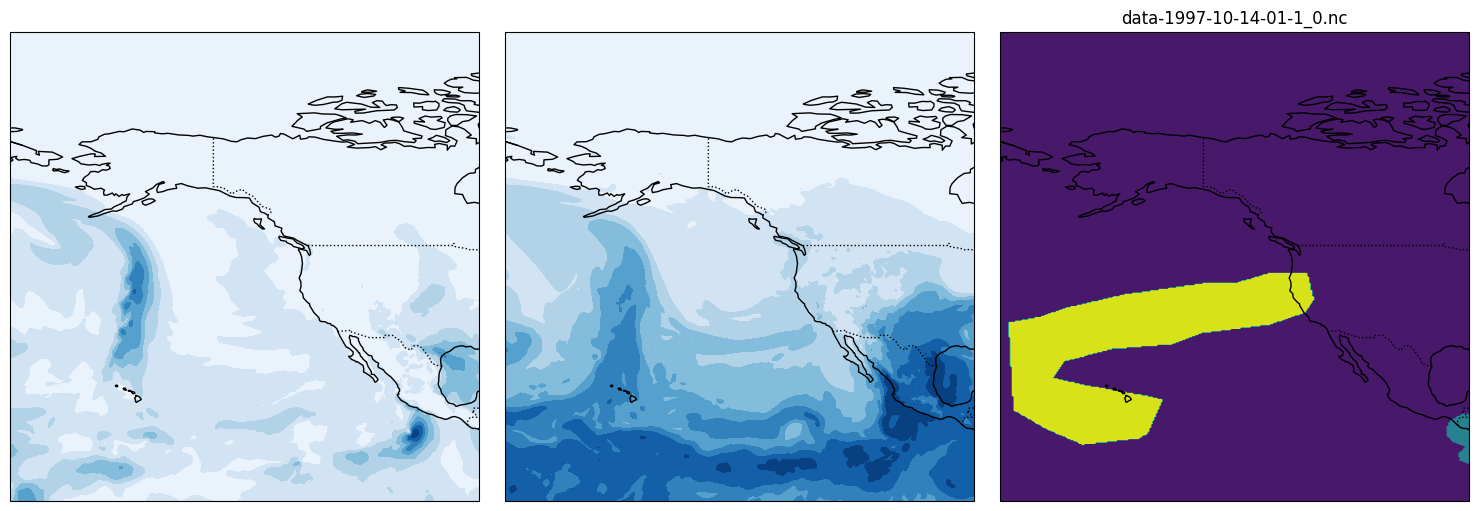

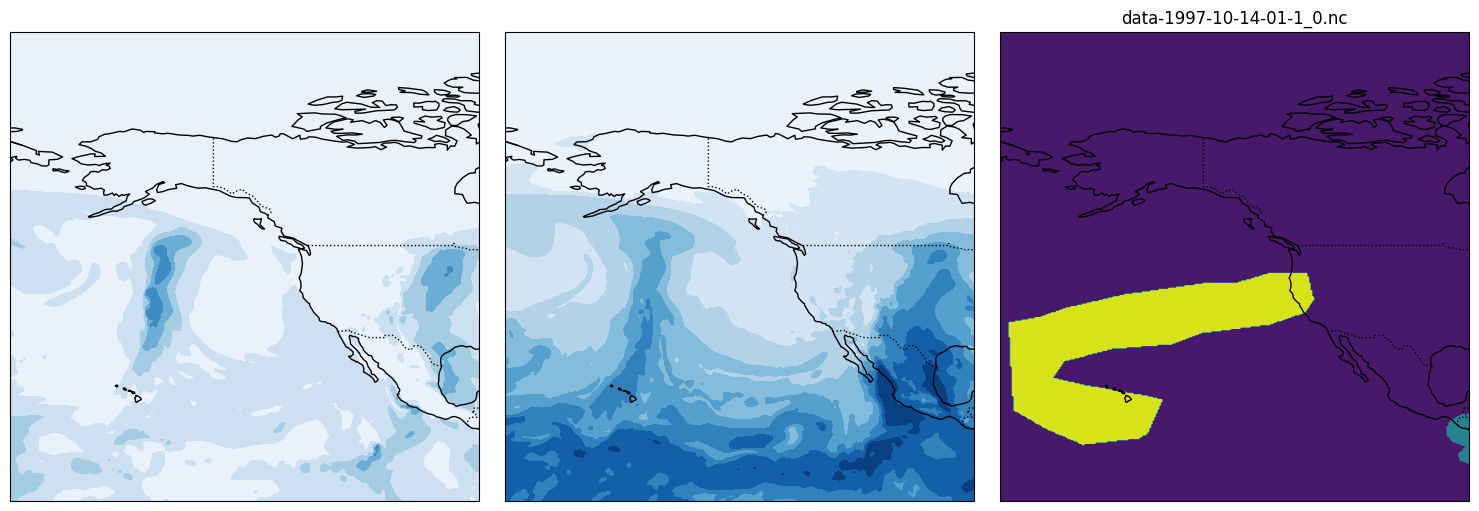

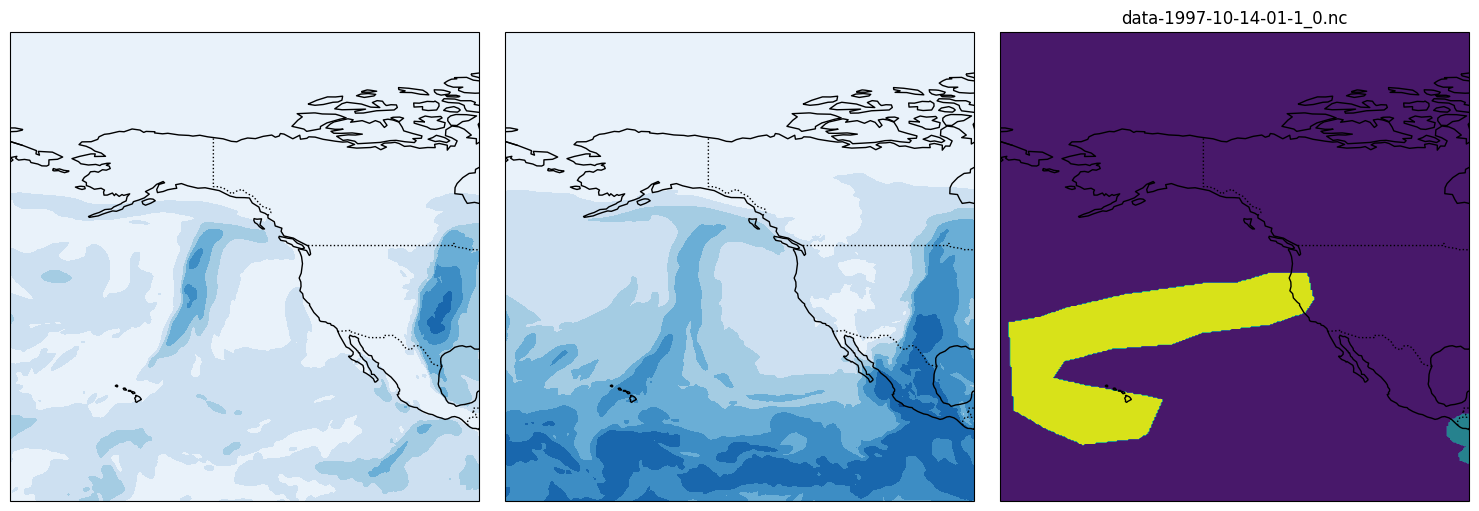

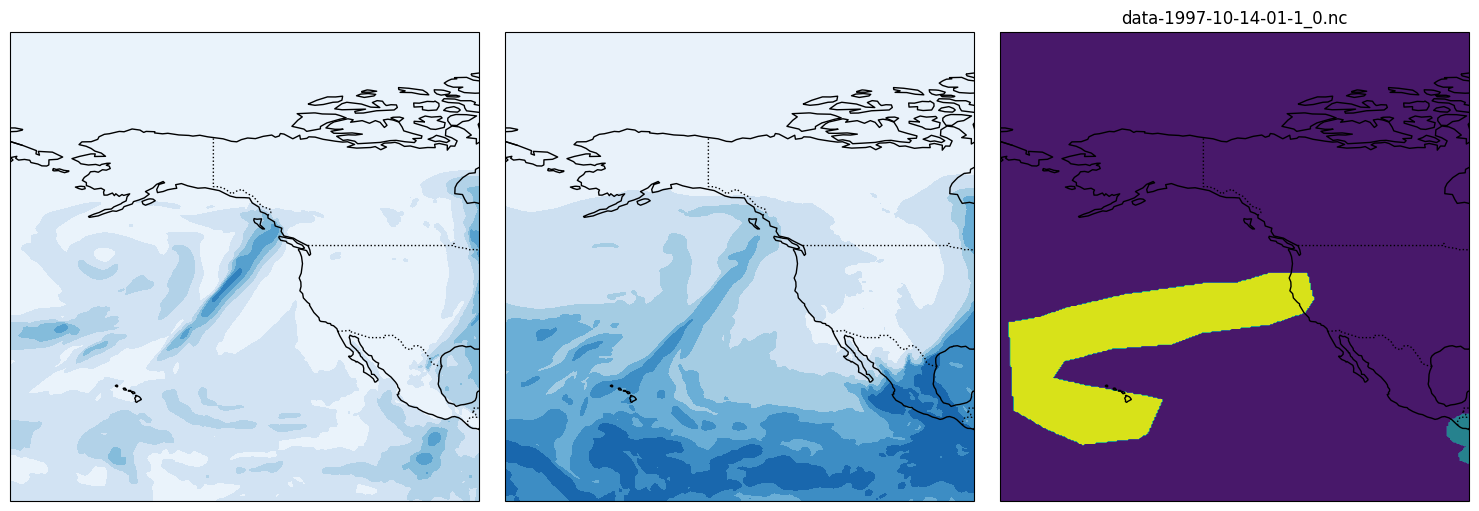

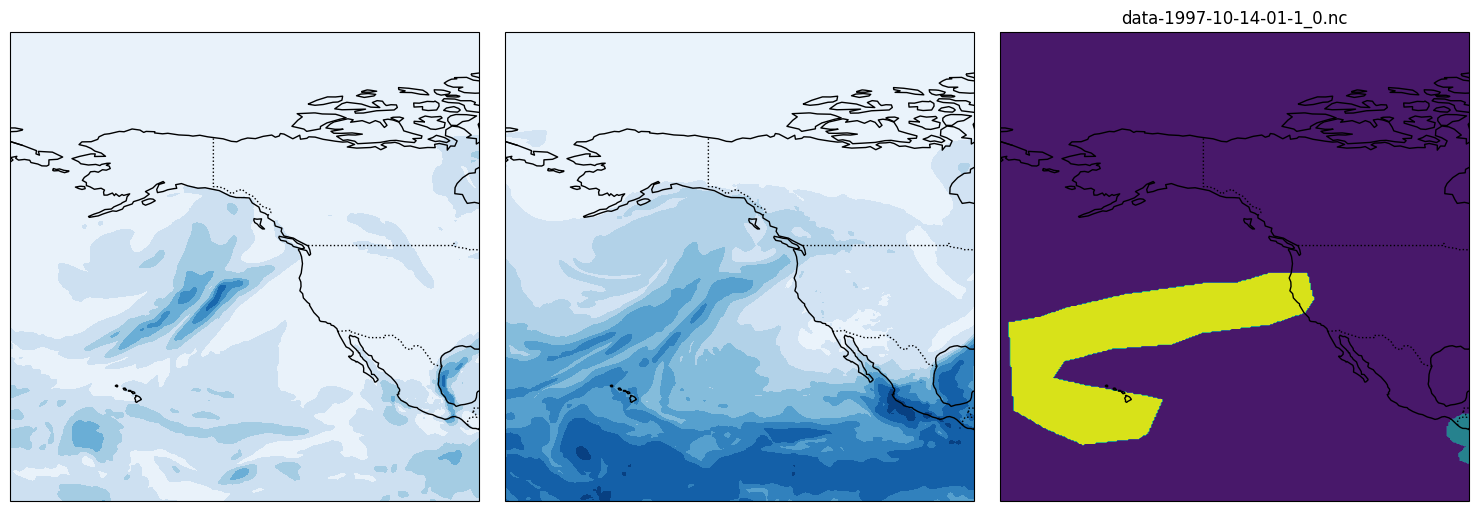

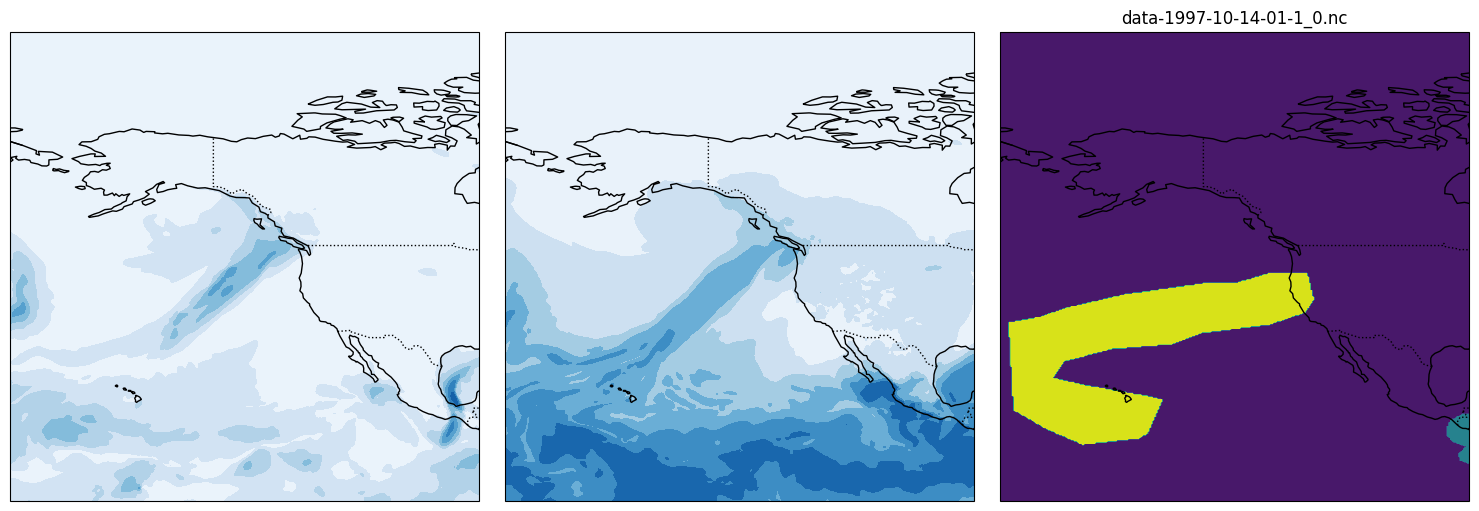

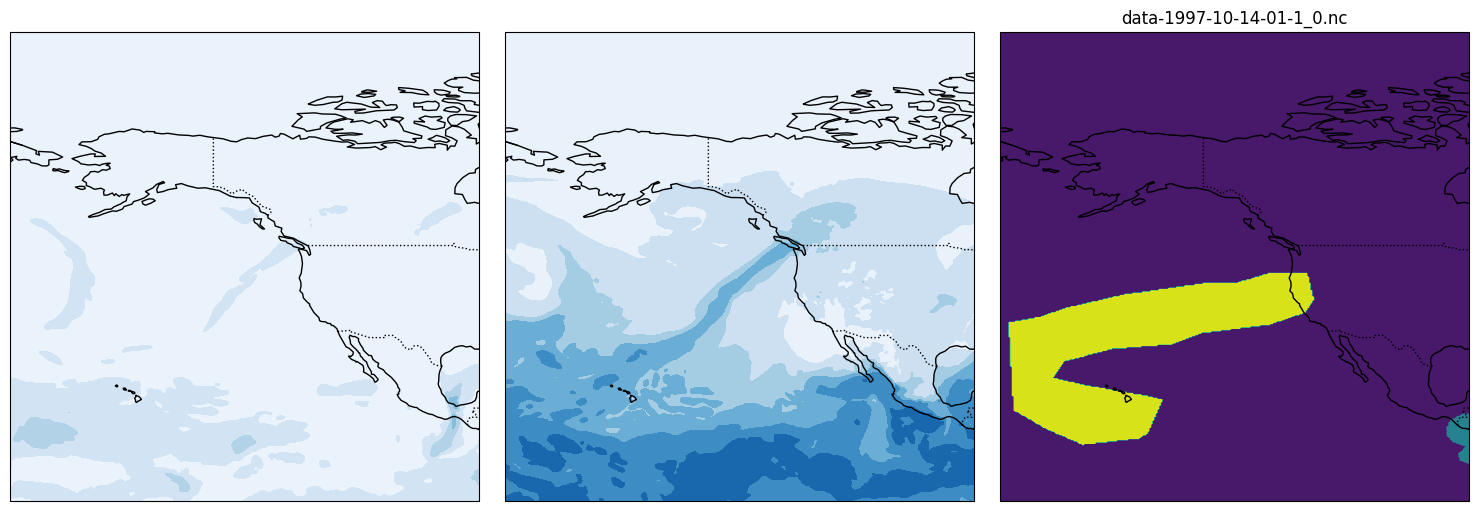

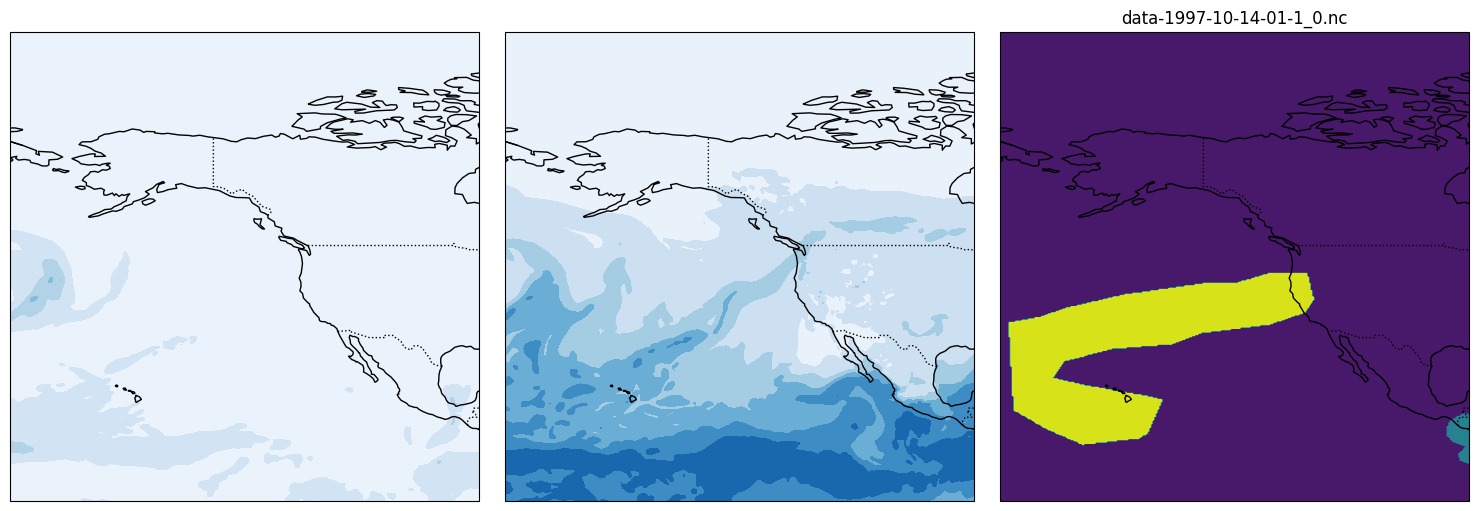

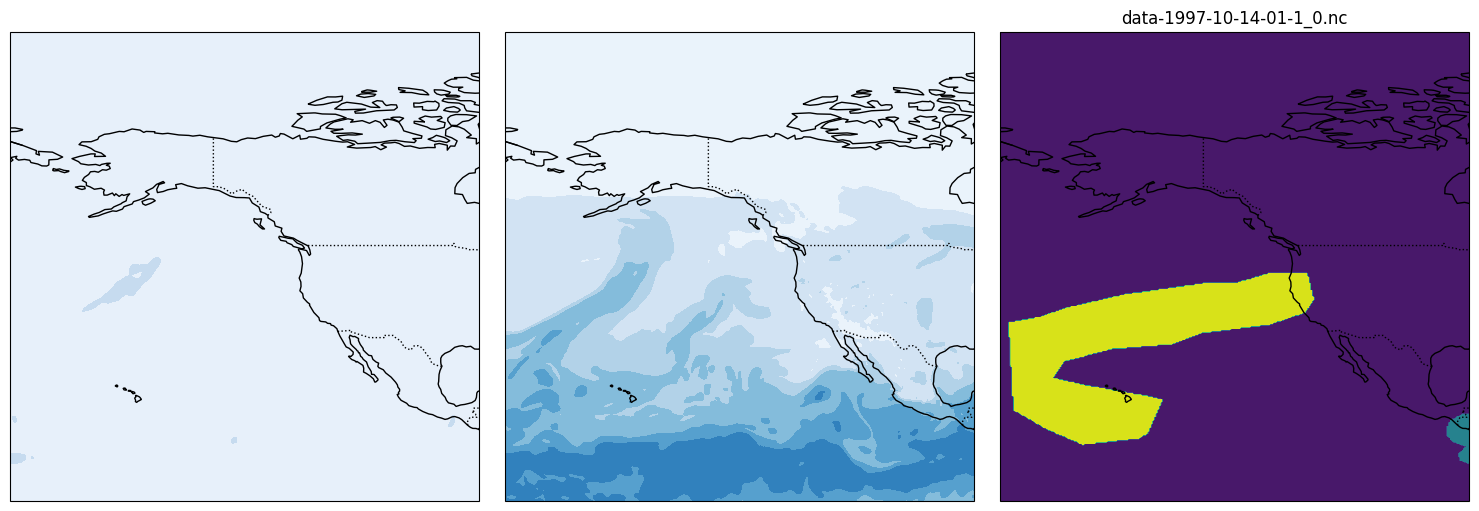

In [ ]:
dataset = nc.Dataset('era5/era5_spH_u_v_1997_10_14.nc', 'r')

for t in range(11):

  lat = dataset.variables['latitude'][:]
  lon = dataset.variables['longitude'][:]
  data_ivt = ivt_multi_levels.data[t,:,:]

  # Set up the map
  fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 5))

  ax[0].add_feature(cfeature.COASTLINE)
  ax[0].add_feature(cfeature.BORDERS, linestyle=':')
  ax[0].contourf(lon, lat, data_ivt, transform=ccrs.PlateCarree(), cmap='Blues')
  ax[0].set_xlabel('Longitude')
  ax[0].set_ylabel('Latitude')
  ax[0].set_xlim(-180, -90)
  ax[0].set_ylim(0, 90)

  data_iwv = iwv[t,:,:]
  ax[1].add_feature(cfeature.COASTLINE)
  ax[1].add_feature(cfeature.BORDERS, linestyle=':')
  ax[1].contourf(lon, lat, data_iwv, transform=ccrs.PlateCarree(), cmap='Blues')
  ax[1].set_xlabel('Longitude')
  ax[1].set_ylabel('Latitude')
  ax[1].set_xlim(-180, -90)
  ax[1].set_ylim(0, 90)

  for f in ['data-1997-10-14-01-1_0.nc']:
    # Change the path to your .nc file
    filename = os.path.join(os.getcwd(),'data',f)

    try:
      dataset_ = nc.Dataset(filename, 'r')
    except:
      continue

    # # Print variable names and their sizes
    # print("Variables in the dataset and their sizes:")
    # for var_name, variable in dataset.variables.items():
    #     print(f"{var_name}: {variable.size}")

    lat = dataset_.variables['lat'][:]
    lon = dataset_.variables['lon'][:]
    data = dataset_.variables['LABELS'][:]

    # Set up the map
    ax[2].add_feature(cfeature.COASTLINE)
    ax[2].add_feature(cfeature.BORDERS, linestyle=':')

    # Add data to the map
    ax[2].contourf(lon, lat, data, transform=ccrs.PlateCarree(), cmap='viridis')

    # Add a colorbar
    # plt.colorbar(ax=ax, orientation='vertical')

    # Title and labels
    ax[2].set_title(f)
    ax[2].set_xlabel('Longitude')
    ax[2].set_ylabel('Latitude')
    ax[2].set_xlim(-180, -90)
    ax[2].set_ylim(0, 90)

  plt.tight_layout()
  plt.show()

  # Close the dataset
  dataset_.close()

(array([5.58925e+05, 2.74416e+05, 1.32574e+05, 4.57390e+04, 1.35210e+04,
        7.27000e+03, 3.78200e+03, 1.48000e+03, 4.26000e+02, 1.07000e+02]),
 array([5.06782476e-05, 2.94410757e+01, 5.88821006e+01, 8.83231256e+01,
        1.17764151e+02, 1.47205176e+02, 1.76646201e+02, 2.06087226e+02,
        2.35528251e+02, 2.64969275e+02, 2.94410300e+02]),
 <BarContainer object of 10 artists>)

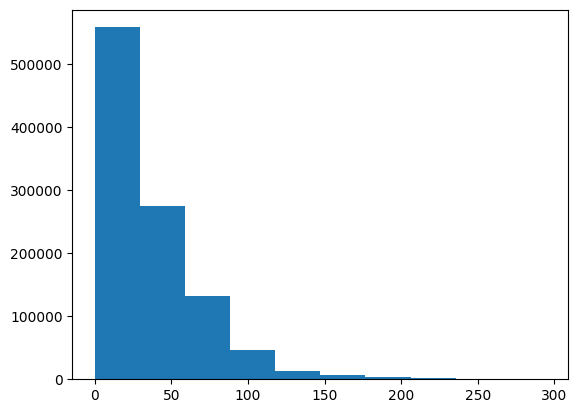

In [ ]:
plt.hist(data_ivt.flatten())

## Find out west US AR positive images

In [ ]:
# Function to slice a NetCDF file to a latitude and longitude extent
def slice_nc_to_extent(file_path, lat_bounds, lon_bounds):
  # Open NetCDF dataset
  data = xr.open_dataset(file_path)

  # Extract latitude and longitude variables
  lat = data['lat']
  lon = data['lon']

  # Find indices corresponding to desired latitude and longitude bounds
  lat_indices = np.where((lat >= lat_bounds[0]) & (lat <= lat_bounds[1]))[0]
  lon_indices = np.where((lon >= lon_bounds[0]) & (lon <= lon_bounds[1]))[0]

  # Ensure there are valid indices to slice
  if len(lat_indices) == 0 or len(lon_indices) == 0:
      raise ValueError("No data found within the specified latitude and longitude bounds.")

  # Slice data to the specified extent
  sliced_data = data.sel(lat=lat[lat_indices], lon=lon[lon_indices])

  data.close()

  return sliced_data

In [ ]:
last_file = np.load('west_ar.npy', allow_pickle=True)[-1]
print(len(np.load('west_ar.npy', allow_pickle=True)))
print(last_file)

278
data/data-2010-10-29-01-1_0.nc


In [ ]:
files = os.listdir('data')
files.sort()

  0%|          | 0/398 [00:00<?, ?it/s]

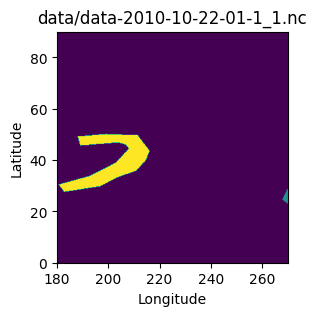

100%|█████████▉| 397/398 [00:01<00:00, 271.57it/s]

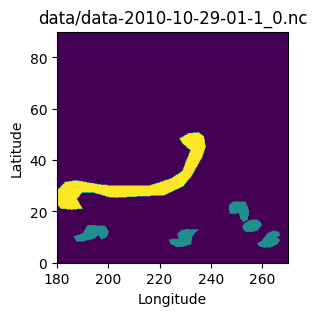

100%|██████████| 398/398 [00:08<00:00, 48.48it/s] 


In [ ]:
try:
  west_ar = list(np.load('west_ar.npy', allow_pickle=True))
except FileNotFoundError:
  west_ar = []

end_date = datetime(int(last_file.split('-')[1]),int(last_file.split('-')[2]),int(last_file.split('-')[3]))

for f in tqdm(files):

  curr_date = datetime(int(f.split('-')[1]),int(f.split('-')[2]),int(f.split('-')[3]))
  if curr_date < end_date:
    continue

  file_path = os.path.join('data',f)
  lat_bounds = (0, 90)  # Example latitude bounds (min, max)
  lon_bounds = (180, 270)  # Example longitude bounds (min, max)

  if f in ['data-1996-07-18-01-1_1.nc','data-1996-10-03-01-1_1.nc']:
    continue

  try:
    if file_path in west_ar:
      continue

    # Slice the NetCDF file to the specified extent
    sliced_data = slice_nc_to_extent(file_path, lat_bounds, lon_bounds)

    # Extract the variable you want to plot (e.g., 'LABEL')
    label_data = sliced_data['LABELS']

    # Plotting code (as previously shown)
    plt.figure(figsize=(3, 3))
    plt.title(file_path)
    plt.imshow(label_data, origin='lower', extent=[lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    label_data = np.array(label_data.data)
    ar_percent = label_data[(label_data==2)].shape[0]/label_data.flatten().shape[0]*100
    if ar_percent>0.02:
      # print('AR')
      west_ar.append(file_path)
      np.save('west_ar.npy', west_ar)

  except ValueError as e:
    print(e)